**Deep Dream**

Enviar uma imagem para uma rede neural e então gerar imagens.

Algumas camadas escondidas são selecionadas na rede. Não utiliza-se a camada de saída. Seleção de algumas camdas convolucionais, evidenciando caracteristicas básicas da imagem.

Sem base de treino e teste.

Nesta arquitetura a saída são as camadas que estão no ínicio

In [64]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np

In [46]:
# Inception Net -> bons resultados
# Camada mixed -> camadas de concatenação dos dados

modelo_base = tf.keras.applications.InceptionV3(include_top = False, weights = 'imagenet')
modelo_base.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_94 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_94 (BatchN  (None, None, None,   96         ['conv2d_94[0][0]']              
 ormalization)                  32)                                                    

In [47]:
# names = ['mixed3', 'mixed5', 'mixed8', 'mixed9'] 
names = ['mixed3', 'mixed5'] # Camadas que serão removidas as ativações da rede

In [48]:
layers = [modelo_base.get_layer(nome).output for nome in names]
layers

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

In [49]:
deep_dream_model = tf.keras.Model(inputs = modelo_base.input, outputs = layers)
deep_dream_model.output

[<KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed3')>,
 <KerasTensor: shape=(None, None, None, 768) dtype=float32 (created by layer 'mixed5')>]

**Carregamento e pré-processamento das imagens**

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


A inception net utiliza imagens de 375 x 225 pixels

In [51]:
imagem = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Mestrado/Cursos - Udemy/Visão computacional/Recursos/Visão Computacional Guia Completo/Images/StaryNight.jpg',
                                               target_size = (225, 375))

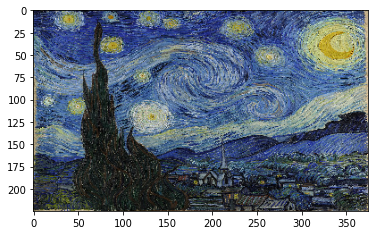

In [52]:
plt.imshow(imagem);

In [53]:
# Convertendoo a imagem para o numpy
imagem = tf.keras.preprocessing.image.img_to_array(imagem)

In [54]:
imagem.shape

(225, 375, 3)

In [55]:
imagem.min(), imagem.max()

(0.0, 255.0)

In [56]:
# Normalizando a imagem
imagem = tf.keras.applications.inception_v3.preprocess_input(imagem)

In [57]:
imagem.min(), imagem.max()

(-1.0, 1.0)

**Camadas de ativação das camadas selecionadas**

In [17]:
imagem_batch = tf.expand_dims(imagem, axis = 0)

In [19]:
ativacoes = deep_dream_model.predict(imagem_batch)

In [20]:
ativacoes[0].shape, ativacoes[1].shape

((1, 12, 21, 768), (1, 12, 21, 768))

**Cálculo do "erro"**

Diferença das respostas entre o esperado e o obtido pela rede.

Nesta rede, apenas muda o valor dos pixels da imagem.

In [67]:
def calcular_erro(imagem, rede):
  imagem_batch = tf.expand_dims(imagem, axis = 0)
  ativacoes = rede(imagem_batch)

  erros = []

  for ativacao in ativacoes:
    # Média das ativações
    media = tf.math.reduce_mean(ativacao)
    erros.append(media)

  # Soma das médias das ativações
  return tf.reduce_sum(erros)

In [59]:
erro = calcular_erro(imagem, deep_dream_model)
erro

<tf.Tensor: shape=(), dtype=float32, numpy=0.61680454>

**Subida do gradiente**

A descida do gradiente busca encontrar a combinação de erros em que o erro é o menor possível.

Na deep dream, utiliza-se as ativações para mudar os pixels da imagem.

A subida do gradiente busca maximizar o erro, busca enfatizar as imagens já treinadas na rede, enfatizar as caracteristicas da imagem. As camadas pooling e convolução possuem essas caracteristicas.

In [65]:
@tf.function # Indica para o tensorflow que esta função será chamada várias vezes durante a execução
def deep_dream(rede, imagem, learning_rate):
  with tf.GradientTape() as tape:
    tape.watch(imagem) # As alterações nos pixels ficaram nessa própria imagem
    erro = calcular_erro(imagem, rede)
  # Indicar para onde os pesos serão atualizados
  # Cálculo da derivada parcial para indicar para onde os valores serão atulizados
  gradientes = tape.gradient(erro, imagem)
  gradientes /= tf.math.reduce_std(gradientes) # Cálculo do desvio padrão
  imagem = imagem + gradientes * learning_rate
  imagem = tf.clip_by_value(imagem, -1, 1) # Deixa os valores na faixa definida

  return erro, imagem

In [61]:
def converter_imagem(imagem):
  # Retornando a imagem na escala -1 até 1 
  # para a escala 0 a 255
  imagem = 255 * (imagem + 1.0) / 2.0
  return tf.cast(imagem, tf.uint8)

In [71]:
def executar_deep_dream(rede, imagem, epocas, learning_rate):
  # learning_rate -> velocidade de transformação das imagens
  # Quanto maior a learning rate mais rápido a execução
  # Quanto menor, melhor serão os resultados
  for epoca in range(epocas):
    erro, imagem = deep_dream(rede, imagem, learning_rate)
    if epoca % 2000 == 0:
      plt.figure(figsize = (12, 12))
      plt.imshow(converter_imagem(imagem))
      plt.show()
      print(f'Época: {epoca}, erro: {erro}')

**Geração das imagens**

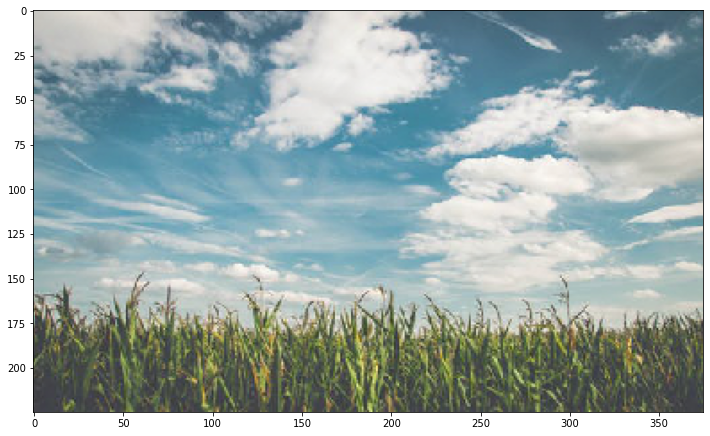

Época: 0, erro: 0.6144235134124756


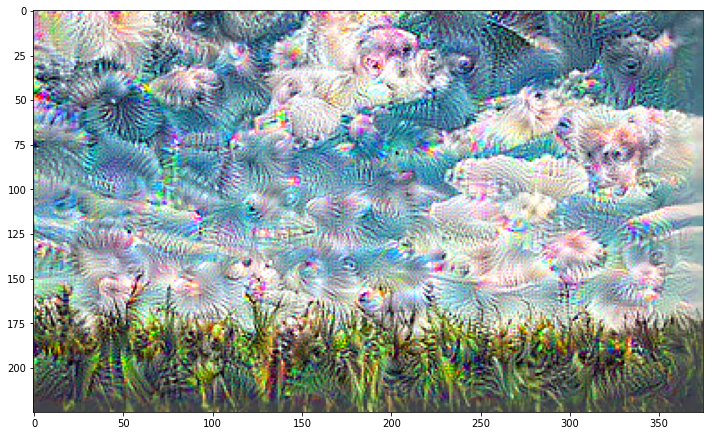

Época: 2000, erro: 2.6166610717773438


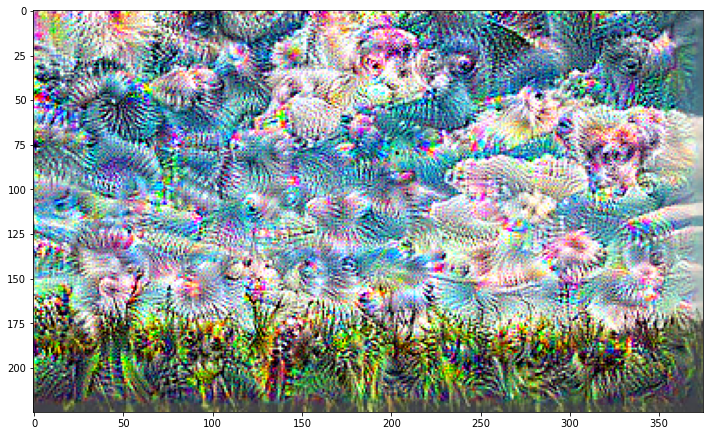

Época: 4000, erro: 3.092480421066284


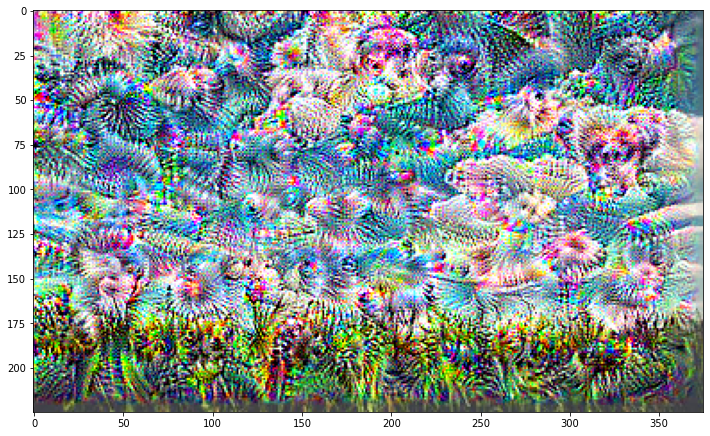

Época: 6000, erro: 3.4391889572143555


In [72]:
executar_deep_dream(deep_dream_model, imagem, 8000, 0.001) 

In [ ]:
# Teste com outra imagem

# Carregando a imagem
imagem = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Mestrado/Cursos - Udemy/Visão computacional/Recursos/Visão Computacional Guia Completo/Images/sky.jpeg',
                                               target_size = (225, 375))

# Mostrando a imagem
plt.imshow(imagem);

# Pré-processando a imagem
imagem = tf.keras.preprocessing.image.img_to_array(imagem)
imagem = tf.keras.applications.inception_v3.preprocess_input(imagem)

# Executando o teste na imagem
executar_deep_dream(deep_dream_model, imagem, 8000, 0.001)